# 1. Biocellion Sensitivity Analysis - Sample
This notebook defines functions to sample input parameters, run simulations and do a sensitivity analysis for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from SALib.sample.morris import sample as morris_sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms

## User settings

In [2]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data")
MODEL_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user")
TOOLS_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-tools")
FIG_FOLDER = Path("./figures")

In [3]:
ABM_CFD_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"
ABM_CFD_MODEL_FOLDER = MODEL_FOLDER / "ABM-microcarriers"
ABM_CFD_PARAMETER_FILE = TOOLS_FOLDER / "SensitivityAnalysis_ABM-CFD_ParameterInfo.csv"

In [ ]:
SEED = 20190605  # Set seed for random number generation to be the date of the first seattle meeting

## Sample the parameter space
We use Morris sampling method to sample the parameter space. It starts at a certain parameter set and generates new ones by changing one at a time. In this way a trajectory through parameter space is set out. By choosing a number of these trajectories in a smart way, the parameter space is sampled evenly. For more information on this method see [Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804) and [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805). We use the package SALib that implements this and other methods along with various helper function. For more information on SALib see [the documentation](https://salib.readthedocs.io/en/latest/).

In [5]:
param_info = pd.read_csv(ABM_CFD_PARAMETER_FILE)
param_info

,Description,name,range_min,range_max,range_type,file,type,manuscript value
0,NaN,STRESS_HILL_EXPONENT,1.000000e+00,10.000000,linear,model_define.h,REAL,NaN
1,NaN,MECH_STRESS_TRESHOLD_DEATH,1.000000e-07,0.000010,exponential,model_define.h,REAL,NaN
2,NaN,STRESS_TRESHOLD,1.000000e-08,0.000001,exponential,model_define.h,REAL,NaN
3,Cell-cell spring constant,A_AGENT_STIFFNESS_CC,1.000000e-04,0.010000,exponential,model_define.h,REAL,0.0010
4,Cell-cell bond flexibility,A_AGENT_BOND_S_CC,1.000000e-02,0.900000,exponential,model_define.h,REAL,0.2000
5,Thresholding factor for cell-cell bond breaking,A_AGENT_BOND_DESTROY_FACTOR_CC,1.000000e+00,1.500000,linear,model_define.h,REAL,1.1000
6,Cell-microcarrier spring constant,A_AGENT_STIFFNESS_CM,2.200000e-04,0.022000,expenential,model_define.h,REAL,0.0022
7,Cell-microcarrier bond flexibility,A_AGENT_BOND_S_CM,1.000000e-02,0.900000,exponential,model_define.h,REAL,0.2000
8,Thresholding factor for cell-microcarrier bond...,A_AGENT_BOND_DESTROY_FACTOR_CM,1.000000e+00,1.500000,linear,model_define.h,REAL,1.1000


In [ ]:
# class ParameterSample:
#     def __init__(self, model_folder, sample_output_folder, param_info_file):
## TODO finish class  

In [6]:
def sample_morris_parameters(parameters, num_levels=4, optimal_trajectories=None, seed=None):
    exp10_select = parameters.loc[parameters.range_type=="exponential", ["range_min", "range_max"]]
    parameters.update(np.log10(exp10_select))
#     print(parameters)

    problem = {
      'num_vars': len(parameters),
      'names': parameters["name"].values.tolist(),
      'bounds': parameters[["range_min","range_max"]].values.tolist()
    }

    param_sample = morris_sample(problem, 10, num_levels=4, optimal_trajectories=optimal_trajectories, seed=SEED)
#     print(param_values)
    for param_vec in param_sample:
        for i in parameters.loc[parameters.range_type=="exponential"].index:
            param_vec[i] = 10**param_vec[i]
    return param_sample, problem

In [15]:
param_sample, problem = sample_morris_parameters(param_info, seed=SEED)

print(np.shape(param_sample))
print(f"This analysis needs approx. {np.round((len(param_sample)*2)/24,1)} days")

(100, 9)
This analysis needs approx. 8.3 days


In [16]:
def sample_scatterplot(x, y, df, problem, param_info):
    if type(x) == int:
        xname = problem["names"][x]
    elif type(x) == str:
        xname = x
    if type(y) == int:
        yname = problem["names"][y]
    elif type(y) == str:
        yname = y
    assert xname in problem["names"]
    assert yname in problem["names"]

    df.plot(problem["names"][x], problem["names"][y], kind="scatter")
    if (param_info.loc[param_info["name"]==xname, "range_type"] == "exponential").values[0]:
        plt.xscale("log")
    if (param_info.loc[param_info["name"]==yname, "range_type"] == "exponential").values[0]:
        plt.yscale("log")
    

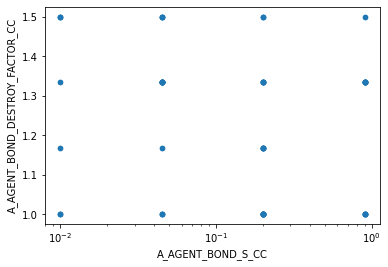

In [18]:
param_sample_df = pd.DataFrame(param_sample, columns=problem["names"])
rng = np.random.default_rng(SEED)
choice = rng.choice(range(len(param_info)), size=2, replace=False)
sample_scatterplot(int(choice[0]), int(choice[1]), param_sample_df, problem, param_info)